In [2]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import yfinance as yf
from datetime import datetime

In [3]:
# Suppress all warnings
import warnings
warnings.simplefilter(action='ignore', category=Warning)

In [4]:
# Set the working directory
os.chdir(r"D:\Benson\aUpWork\Douglas Backtester Algo\Backtester Algorithm\Data")

## STRATEGY 3 INVESTMENT RULES

- enter when vix is less than 20 (range is 0 to 20) and VVIX is less than 95 (range is 95 to 0)

- exit if VVIX goes above 100, or VIX goes above 20



In [5]:
# Load the data
data = pd.read_csv("All Assets and Dividends.csv")

# Convert the Date column to datetime format
data["Date"] = pd.to_datetime(data["Date"])

# reorder the position of columns
data = data[['Date', 'YMAX', 'YMAX Dividends', 'YMAG', 'YMAG Dividends', 'VIX', 'VVIX', 'QQQ']]


#view the data
data.head()


,Date,YMAX,YMAX Dividends,YMAG,YMAG Dividends,VIX,VVIX,QQQ
0,2024-01-31,20.20,0.0,19.49,0.0,14.35,87.559998,414.506744
1,2024-02-01,20.39,0.0,19.75,0.0,13.88,84.830002,419.387726
2,2024-02-02,20.70,0.0,20.30,0.0,13.85,83.309998,426.475586
3,2024-02-05,20.44,0.0,20.19,0.0,13.67,79.580002,425.918945
4,2024-02-06,20.61,0.0,20.20,0.0,13.06,76.970001,425.063995


# YMAX STRATEGY 3 BACKTEST

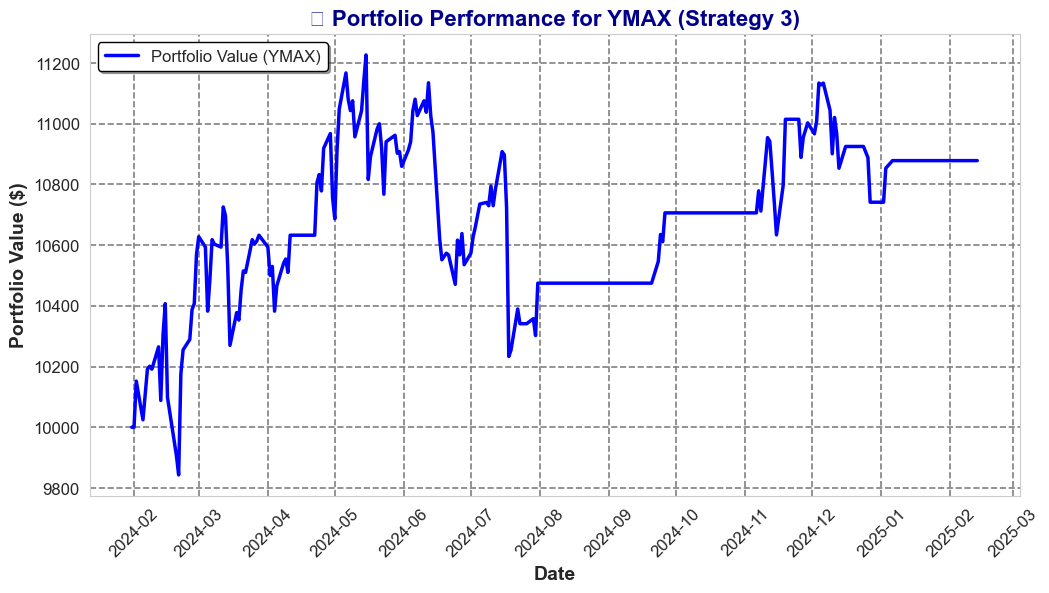

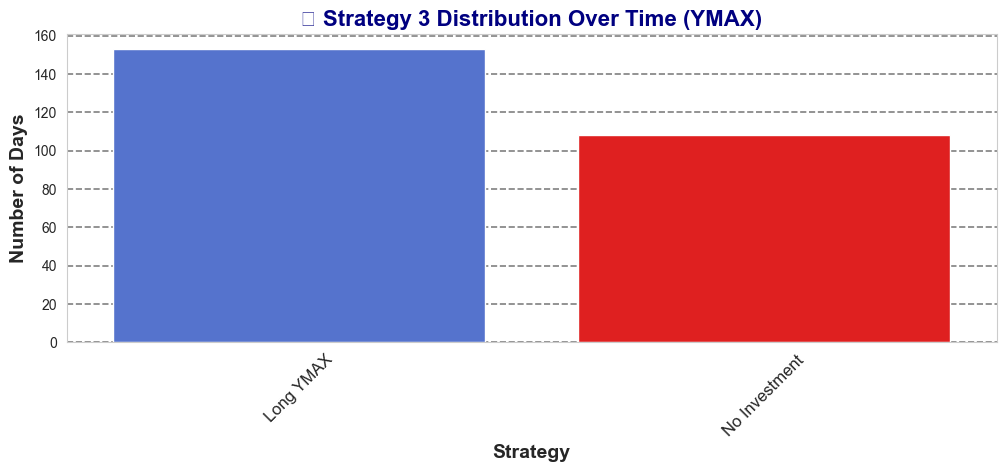

In [6]:
# ------------------------------------------------------------
# 1) PREPARE THE DATA
# ------------------------------------------------------------
ymax_df = data.copy()

# Define initial portfolio value
initial_investment = 10000.0  # $10,000 starting capital

# Sort by date to ensure chronological order
ymax_df.sort_values("Date", inplace=True)
ymax_df.reset_index(drop=True, inplace=True)

# ------------------------------------------------------------
# 2) DEFINE HELPER FUNCTIONS FOR CONDITIONS
# ------------------------------------------------------------
# Function to check if we are in the market (entry/in-market condition)
def in_market_condition(vix, vvix):
    """
    Condition for entering or remaining in the market:
    Enter when VIX < 20 and VVIX < 95.
    """
    return (vix < 20) and (vvix < 95)

# Function to check the exit condition
def exit_condition(vix, vvix):
    """
    Exit the market if:
    VIX > 20 or VVIX > 100.
    """
    return (vix > 20) or (vvix > 100)

# ------------------------------------------------------------
# 3) SET UP BACKTEST COLUMNS AND INITIAL VALUES
# ------------------------------------------------------------
ymax_df["Portfolio_Value"] = np.nan
ymax_df.loc[0, "Portfolio_Value"] = initial_investment

# Boolean: are we currently invested?
ymax_df["In_Market"] = False
ymax_df.loc[0, "In_Market"] = False

# Track how many shares of YMAX we hold
ymax_df["Shares_Held"] = 0.0
ymax_df.loc[0, "Shares_Held"] = 0.0

# Strategy label for each day
ymax_df["Strategy"] = "No Investment"

# ------------------------------------------------------------
# 4) BACKTEST LOOP
# ------------------------------------------------------------
for i in range(1, len(ymax_df)):
    # Carry forward the previous day's portfolio value, in-market status, and shares held
    ymax_df.loc[i, "Portfolio_Value"] = ymax_df.loc[i-1, "Portfolio_Value"]
    ymax_df.loc[i, "In_Market"] = ymax_df.loc[i-1, "In_Market"]
    ymax_df.loc[i, "Shares_Held"] = ymax_df.loc[i-1, "Shares_Held"]

    # Current day data
    vix_today = ymax_df.loc[i, "VIX"]
    vvix_today = ymax_df.loc[i, "VVIX"]
    ymax_price_today = ymax_df.loc[i, "YMAX"]
    ymax_div_today = ymax_df.loc[i, "YMAX Dividends"]

    # Are we in the market at the start of today?
    currently_in_market = ymax_df.loc[i-1, "In_Market"]

    if currently_in_market:
        # If in the market, check if we need to exit
        if exit_condition(vix_today, vvix_today):
            # EXIT: close position -> set shares to 0, remain in cash
            ymax_df.loc[i, "In_Market"] = False
            ymax_df.loc[i, "Shares_Held"] = 0.0
            ymax_df.loc[i, "Strategy"] = "No Investment"
            # Portfolio_Value remains the same (carried forward)
        else:
            # REMAIN IN MARKET: update portfolio value based on today's price and dividend
            shares_held = ymax_df.loc[i, "Shares_Held"]
            new_portfolio_value = shares_held * (ymax_price_today + ymax_div_today)
            ymax_df.loc[i, "Portfolio_Value"] = new_portfolio_value
            ymax_df.loc[i, "Strategy"] = "Long YMAX"
    else:
        # If currently out of the market, check if entry (in-market) condition is met
        if in_market_condition(vix_today, vvix_today):
            # ENTER: buy shares with all available cash
            cash_available = ymax_df.loc[i, "Portfolio_Value"]
            if ymax_price_today > 0:
                shares_bought = cash_available / ymax_price_today
                ymax_df.loc[i, "Shares_Held"] = shares_bought
                ymax_df.loc[i, "In_Market"] = True
                ymax_df.loc[i, "Strategy"] = "Long YMAX"
                # Immediately update portfolio value with today's price and dividend
                new_portfolio_value = shares_bought * (ymax_price_today + ymax_div_today)
                ymax_df.loc[i, "Portfolio_Value"] = new_portfolio_value
            else:
                # If the price is 0 or invalid, skip entry
                ymax_df.loc[i, "Strategy"] = "No Investment"
        else:
            # Remain out of the market
            ymax_df.loc[i, "Strategy"] = "No Investment"

# ------------------------------------------------------------
# 5) COMPUTE DAILY RETURNS
# ------------------------------------------------------------
ymax_df["Portfolio_Return"] = ymax_df["Portfolio_Value"].pct_change()

# ------------------------------------------------------------
# 6) VISUALIZE RESULTS
# ------------------------------------------------------------
sns.set_style("whitegrid")

# (A) Portfolio Performance Plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    x=ymax_df["Date"],
    y=ymax_df["Portfolio_Value"],
    color="blue",
    linewidth=2.5,
    label="Portfolio Value (YMAX)"
)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel("Date", fontsize=14, fontweight="bold")
plt.ylabel("Portfolio Value ($)", fontsize=14, fontweight="bold")
plt.title("📈 Portfolio Performance for YMAX (Strategy 3)", fontsize=16, fontweight="bold", color="darkblue")
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", linewidth=1.2, color="gray")
plt.legend(fontsize=12, loc="upper left", frameon=True, shadow=True, edgecolor="black")
plt.show()

# (B) Strategy Usage Over Time
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=ymax_df["Strategy"].value_counts().index,
    y=ymax_df["Strategy"].value_counts().values,
    palette=["royalblue", "red", "green"]
)
plt.xlabel("Strategy", fontsize=14, fontweight="bold")
plt.ylabel("Number of Days", fontsize=14, fontweight="bold")
plt.title("📊 Strategy 3 Distribution Over Time (YMAX)", fontsize=16, fontweight="bold", color="navy")
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=1.2, color="gray")
plt.show()


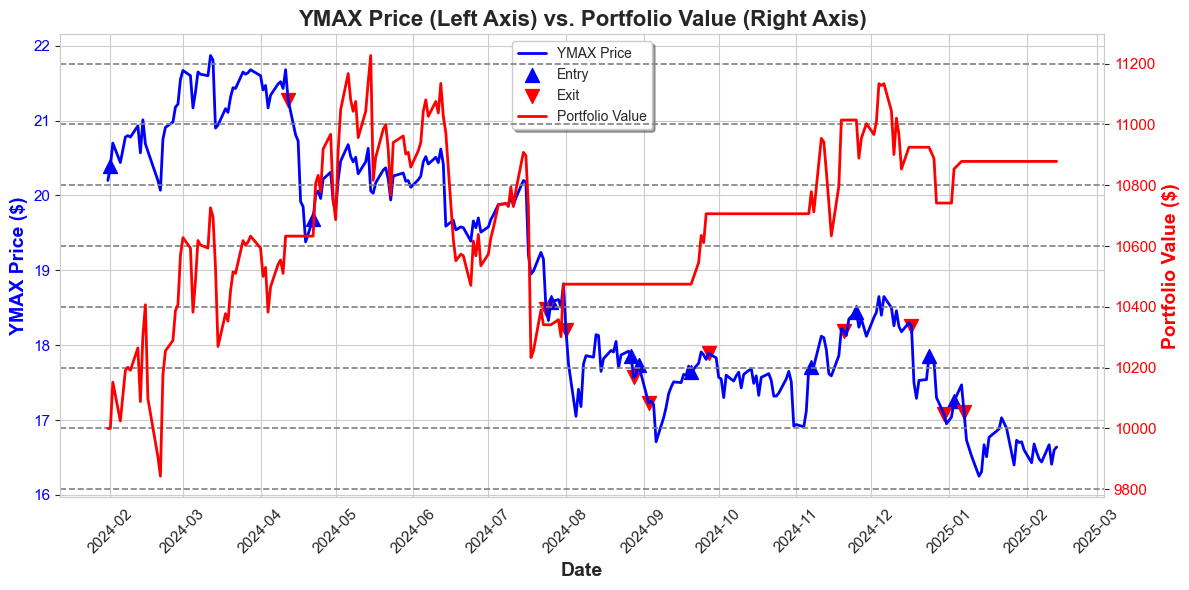

In [7]:
# ---------------------------------------------
# STEP A: Identify Entry and Exit Days
# ---------------------------------------------
# Entry Day = Yesterday was out of market, today is in market
ymax_df["Entry"] = (ymax_df["In_Market"].shift(1) == False) & (ymax_df["In_Market"] == True)

# Exit Day = Yesterday was in market, today is out of market
ymax_df["Exit"] = (ymax_df["In_Market"].shift(1) == True) & (ymax_df["In_Market"] == False)

# ---------------------------------------------
# STEP B: Prepare Data for Plotting
# ---------------------------------------------
entry_days = ymax_df[ymax_df["Entry"] == True]
exit_days  = ymax_df[ymax_df["Exit"] == True]

# Sort data by date (just to be safe)
ymax_df.sort_values("Date", inplace=True)
ymax_df.reset_index(drop=True, inplace=True)

# ---------------------------------------------
# STEP C: Create the Dual-Axis Plot
# ---------------------------------------------
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

# LEFT Y-AXIS: Plot YMAX Price
ax1.set_xlabel("Date", fontsize=14, fontweight="bold")
ax1.set_ylabel("YMAX Price ($)", fontsize=14, fontweight="bold", color="blue")

# Plot YMAX Price line
line1, = ax1.plot(ymax_df["Date"], ymax_df["YMAX"], color="blue", linewidth=2, label="YMAX Price")

# Add entry (^) and exit (v) markers on YMAX
ax1.scatter(entry_days["Date"], entry_days["YMAX"], marker="^", color="blue", s=100, label="Entry")
ax1.scatter(exit_days["Date"], exit_days["YMAX"], marker="v", color="red", s=100, label="Exit")

# Make the left y-axis text blue for clarity
ax1.tick_params(axis='y', labelcolor="blue")

# Format the date axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)

# ---------------------------------------------
# RIGHT Y-AXIS: Plot Portfolio Value
# ---------------------------------------------
ax2 = ax1.twinx()  # share the same x-axis
ax2.set_ylabel("Portfolio Value ($)", fontsize=14, fontweight="bold", color="red")

line2, = ax2.plot(
    ymax_df["Date"],
    ymax_df["Portfolio_Value"],
    color="red",
    linewidth=2,
    label="Portfolio Value"
)
ax2.tick_params(axis='y', labelcolor="red")
plt.yticks(fontsize=11)

# ---------------------------------------------
# STEP D: Enhance the Plot
# ---------------------------------------------
plt.title("YMAX Price (Left Axis) vs. Portfolio Value (Right Axis)", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", linewidth=1.2, color="gray")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper center", frameon=True, shadow=True)

plt.tight_layout()
plt.show()


In [8]:
import plotly.graph_objects as go

# ---------------------------------------------
# STEP A: Identify Entry and Exit Days
# ---------------------------------------------
ymax_df["Entry"] = (ymax_df["In_Market"].shift(1) == False) & (ymax_df["In_Market"] == True)
ymax_df["Exit"]  = (ymax_df["In_Market"].shift(1) == True) & (ymax_df["In_Market"] == False)

# ---------------------------------------------
# STEP B: Prepare Data for Plotting
# ---------------------------------------------
entry_days = ymax_df[ymax_df["Entry"] == True]
exit_days  = ymax_df[ymax_df["Exit"] == True]

# Sort data by date
ymax_df.sort_values("Date", inplace=True)
ymax_df.reset_index(drop=True, inplace=True)

# ---------------------------------------------
# STEP C: Create Plotly Figure
# ---------------------------------------------
fig = go.Figure()

# 1) YMAX Price (Left Axis)
fig.add_trace(
    go.Scatter(
        x=ymax_df["Date"],
        y=ymax_df["YMAX"],
        mode="lines",
        line=dict(color="blue", width=2),
        name="YMAX Price",
        yaxis="y1"
    )
)

# 2) Entry Markers (triangle-up)
fig.add_trace(
    go.Scatter(
        x=entry_days["Date"],
        y=entry_days["YMAX"],
        mode="markers",
        marker=dict(symbol="triangle-up", color="blue", size=12),
        name="Entry",
        yaxis="y1"
    )
)

# 3) Exit Markers (triangle-down)
fig.add_trace(
    go.Scatter(
        x=exit_days["Date"],
        y=exit_days["YMAX"],
        mode="markers",
        marker=dict(symbol="triangle-down", color="red", size=12),
        name="Exit",
        yaxis="y1"
    )
)

# 4) Portfolio Value (Right Axis)
fig.add_trace(
    go.Scatter(
        x=ymax_df["Date"],
        y=ymax_df["Portfolio_Value"],
        mode="lines",
        line=dict(color="red", width=2),
        name="Portfolio Value",
        yaxis="y2"
    )
)

# ---------------------------------------------
# STEP D: Configure Layout for Dual Axis
# ---------------------------------------------
fig.update_layout(
    title="YMAX Price (Left Axis) vs. Portfolio Value (Right Axis) - Interactive Plotly",
    xaxis=dict(
        title="Date",
        type="date",
        tickformat="%Y-%m",
        tickangle=45
    ),
    yaxis=dict(
        title="YMAX Price ($)",
        side="left",
        showgrid=False,
        color="blue"
    ),
    yaxis2=dict(
        title="Portfolio Value ($)",
        side="right",
        overlaying="y",
        position=1.0,
        showgrid=True,
        gridwidth=1,
        gridcolor="lightgray",
        color="red"
    ),
    legend=dict(
        x=1.0,
        y=1.0,
        xanchor='center',
        yanchor='top',
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="black",
        borderwidth=1
    ),
    hovermode="x unified"
)

# ---------------------------------------------
# STEP E: Show Interactive Figure
# ---------------------------------------------
fig.show()


In [9]:
import nbformat
print(nbformat.__version__)


5.10.4


## Performance Metrics for Strategy 2 on YMAX

In [10]:
# ---------------------------------------------
# STEP 1: Compute Performance Metrics for Strategy 2 on YMAX
# ---------------------------------------------
# Compute daily returns from portfolio value (if not already computed)
ymax_df["Portfolio_Return"] = ymax_df["Portfolio_Value"].pct_change()

performance_metrics = {}

# Total Return (%)
performance_metrics["Total Return (%)"] = (ymax_df["Portfolio_Value"].iloc[-1] / ymax_df["Portfolio_Value"].iloc[0] - 1) * 100

# CAGR (Compounded Annual Growth Rate) (%)
num_days = (ymax_df["Date"].iloc[-1] - ymax_df["Date"].iloc[0]).days
years = num_days / 365
performance_metrics["CAGR (%)"] = ((ymax_df["Portfolio_Value"].iloc[-1] / ymax_df["Portfolio_Value"].iloc[0]) ** (1 / years) - 1) * 100

# Annualized Volatility (%)
performance_metrics["Annualized Volatility (%)"] = ymax_df["Portfolio_Return"].std() * np.sqrt(252) * 100

# Sharpe Ratio (assuming risk-free rate = 2%)
risk_free_rate = 0.02
sharpe_ratio = (performance_metrics["CAGR (%)"] / 100 - risk_free_rate) / (performance_metrics["Annualized Volatility (%)"] / 100)
performance_metrics["Sharpe Ratio"] = sharpe_ratio

# Max Drawdown (%) Calculation
rolling_max = ymax_df["Portfolio_Value"].cummax()
drawdown = (ymax_df["Portfolio_Value"] / rolling_max) - 1  # Decimal values (e.g., -0.10 for -10%)
drawdown_percentage = drawdown * 100  # Convert to percentage
performance_metrics["Max Drawdown (%)"] = drawdown_percentage.min()  # Most negative value

# Calmar Ratio (CAGR / |Max Drawdown|)
max_drawdown_abs = abs(performance_metrics["Max Drawdown (%)"])
performance_metrics["Calmar Ratio"] = performance_metrics["CAGR (%)"] / max_drawdown_abs if max_drawdown_abs != 0 else np.nan

# Convert metrics to a DataFrame for display
performance_df = pd.DataFrame(performance_metrics, index=["YMAX Strategy 2"])

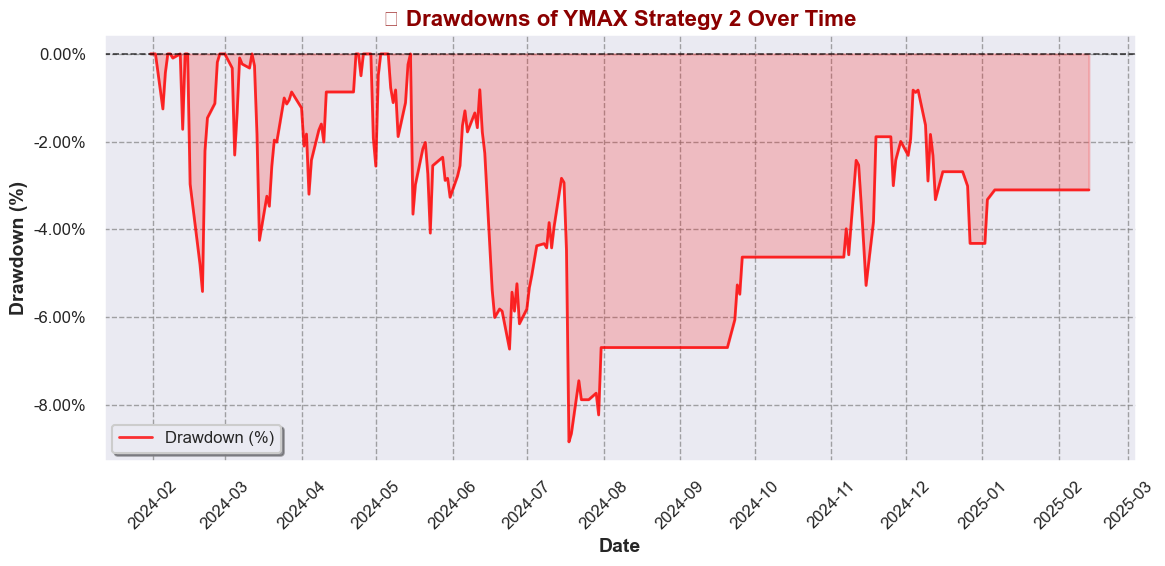

In [21]:
# ---------------------------------------------
# STEP 2: Plot Drawdown Over Time (Improved)
# ---------------------------------------------
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

sns.set_style("darkgrid")
sns.set_context("talk")  # Larger labels and a more "presentation-friendly" look

plt.figure(figsize=(12, 6))

# Draw the main drawdown line
ax = sns.lineplot(x=ymax_df["Date"],  y=drawdown_percentage, color="red",  linewidth=2, label="Drawdown (%)", alpha=0.8)

# Fill the area under the curve from drawdown to 0% (for negative drawdowns)
plt.fill_between(
    ymax_df["Date"],
    drawdown_percentage,
    0,
    where=(drawdown_percentage <= 0),
    interpolate=True,
    color="red",
    alpha=0.2
)

# Format the X-axis to display months
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Format Y-axis labels as percentages
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:.2f}%"))

# Add a horizontal line at 0% for reference
ax.axhline(0, color="black", linewidth=1.2, linestyle="--", alpha=0.7)

# Labels and title
plt.xlabel("Date", fontsize=14, fontweight="bold")
plt.ylabel("Drawdown (%)", fontsize=14, fontweight="bold")
plt.title(
    "📉 Drawdowns of YMAX Strategy 2 Over Time",
    fontsize=16,
    fontweight="bold",
    color="darkred"
)

# Improved grid style
plt.grid(True, linestyle="--", linewidth=1.0, color="gray", alpha=0.7)

# Legend
plt.legend(fontsize=12, loc="best", frameon=True, shadow=True)

plt.tight_layout()
plt.show()


In [12]:
# Display the performance metrics for YMAX
performance_df_ymax = performance_df
performance_df_ymax = performance_df_ymax.round(2)
performance_df_ymax

,Total Return (%),CAGR (%),Annualized Volatility (%),Sharpe Ratio,Max Drawdown (%),Calmar Ratio
YMAX Strategy 2,8.78,8.45,13.55,0.48,-8.85,0.95


# YMAG STRATEGY 3 BACKTEST

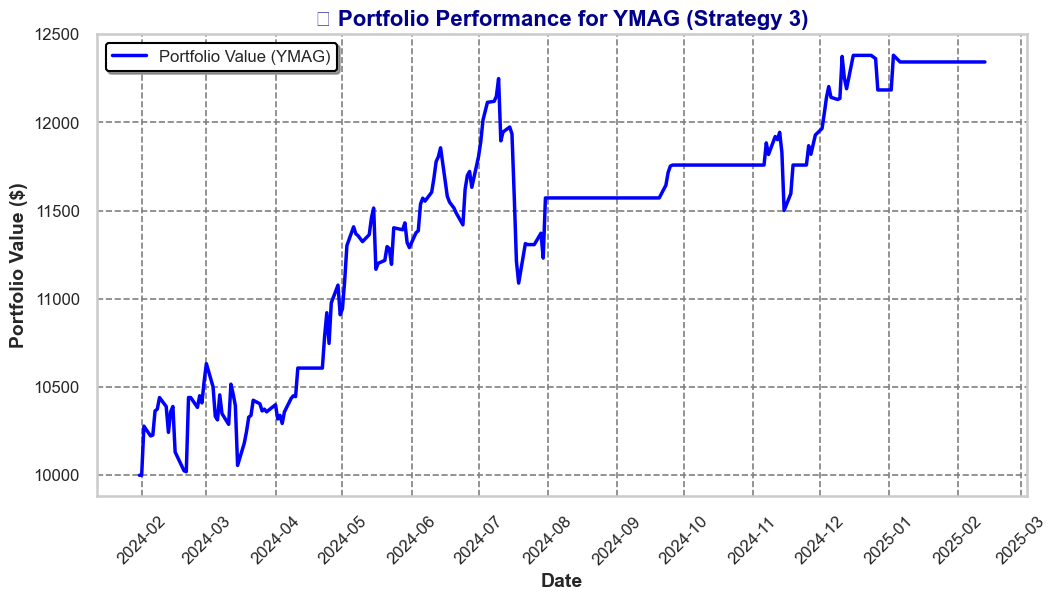

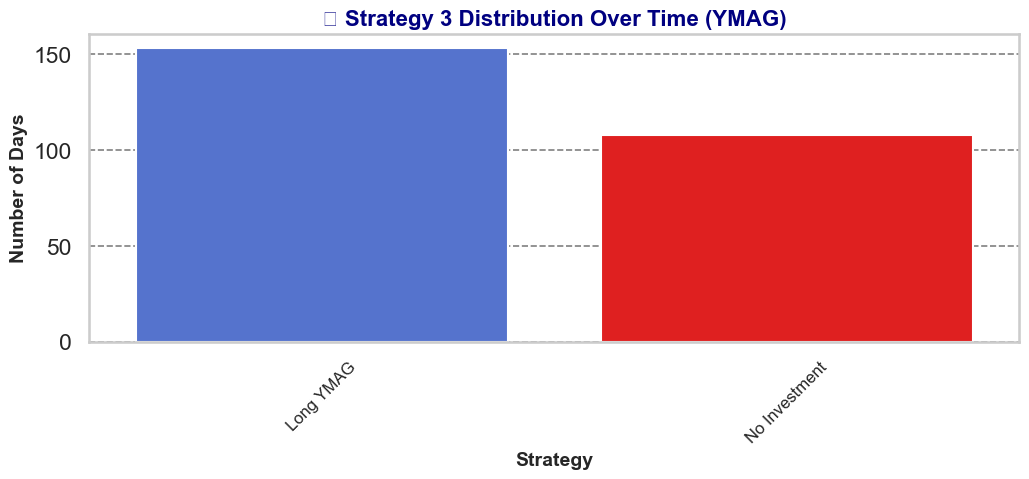

In [13]:
# ------------------------------------------------------------
# 1) PREPARE THE DATA
# ------------------------------------------------------------
ymag_df = data.copy()

# Define initial portfolio value
initial_investment = 10000.0  # $10,000 starting capital

# Sort by date to ensure chronological order
ymag_df.sort_values("Date", inplace=True)
ymag_df.reset_index(drop=True, inplace=True)

# ------------------------------------------------------------
# 2) DEFINE HELPER FUNCTIONS FOR CONDITIONS
# ------------------------------------------------------------
# Function to check if we are in the market (entry/in-market condition)
def in_market_condition(vix, vvix):
    """
    Enter (or remain in) the market when:
    VIX < 20 and VVIX < 95.
    """
    return (vix < 20) and (vvix < 95)

# Function to check the exit condition
def exit_condition(vix, vvix):
    """
    Exit the market if either:
    VIX > 20 or VVIX > 100.
    """
    return (vix > 20) or (vvix > 100)

# ------------------------------------------------------------
# 3) SET UP BACKTEST COLUMNS AND INITIAL VALUES
# ------------------------------------------------------------
ymag_df["Portfolio_Value"] = np.nan
ymag_df.loc[0, "Portfolio_Value"] = initial_investment

# Boolean: are we currently invested?
ymag_df["In_Market"] = False
ymag_df.loc[0, "In_Market"] = False

# Track how many shares of YMAG we hold
ymag_df["Shares_Held"] = 0.0
ymag_df.loc[0, "Shares_Held"] = 0.0

# Strategy label for each day
ymag_df["Strategy"] = "No Investment"

# ------------------------------------------------------------
# 4) BACKTEST LOOP
# ------------------------------------------------------------
for i in range(1, len(ymag_df)):
    # Carry forward previous day's portfolio value, in-market status, and shares held
    ymag_df.loc[i, "Portfolio_Value"] = ymag_df.loc[i-1, "Portfolio_Value"]
    ymag_df.loc[i, "In_Market"] = ymag_df.loc[i-1, "In_Market"]
    ymag_df.loc[i, "Shares_Held"] = ymag_df.loc[i-1, "Shares_Held"]

    # Current day data
    vix_today = ymag_df.loc[i, "VIX"]
    vvix_today = ymag_df.loc[i, "VVIX"]
    ymag_price_today = ymag_df.loc[i, "YMAG"]
    ymag_div_today = ymag_df.loc[i, "YMAG Dividends"]

    # Are we in the market at the start of today?
    currently_in_market = ymag_df.loc[i-1, "In_Market"]

    if currently_in_market:
        # If in the market, check if we need to exit
        if exit_condition(vix_today, vvix_today):
            # EXIT: close position -> set shares to 0, remain in cash
            ymag_df.loc[i, "In_Market"] = False
            ymag_df.loc[i, "Shares_Held"] = 0.0
            ymag_df.loc[i, "Strategy"] = "No Investment"
            # Portfolio_Value remains unchanged (carried forward)
        else:
            # REMAIN IN MARKET: update portfolio value based on today's price and dividend
            shares_held = ymag_df.loc[i, "Shares_Held"]
            new_portfolio_value = shares_held * (ymag_price_today + ymag_div_today)
            ymag_df.loc[i, "Portfolio_Value"] = new_portfolio_value
            ymag_df.loc[i, "Strategy"] = "Long YMAG"
    else:
        # If currently out of the market, check if entry (in-market) condition is met
        if in_market_condition(vix_today, vvix_today):
            # ENTER: buy shares with all available cash
            cash_available = ymag_df.loc[i, "Portfolio_Value"]
            if ymag_price_today > 0:
                shares_bought = cash_available / ymag_price_today
                ymag_df.loc[i, "Shares_Held"] = shares_bought
                ymag_df.loc[i, "In_Market"] = True
                ymag_df.loc[i, "Strategy"] = "Long YMAG"
                # Immediately update portfolio value with today's price and dividend
                new_portfolio_value = shares_bought * (ymag_price_today + ymag_div_today)
                ymag_df.loc[i, "Portfolio_Value"] = new_portfolio_value
            else:
                # If price is 0 or invalid, skip entry
                ymag_df.loc[i, "Strategy"] = "No Investment"
        else:
            # Remain out of the market
            ymag_df.loc[i, "Strategy"] = "No Investment"

# ------------------------------------------------------------
# 5) COMPUTE DAILY RETURNS
# ------------------------------------------------------------
ymag_df["Portfolio_Return"] = ymag_df["Portfolio_Value"].pct_change()

# ------------------------------------------------------------
# 6) VISUALIZE RESULTS
# ------------------------------------------------------------
sns.set_style("whitegrid")

# (A) Portfolio Performance Plot
plt.figure(figsize=(12, 6))
ax = sns.lineplot(
    x=ymag_df["Date"],
    y=ymag_df["Portfolio_Value"],
    color="blue",
    linewidth=2.5,
    label="Portfolio Value (YMAG)"
)
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xlabel("Date", fontsize=14, fontweight="bold")
plt.ylabel("Portfolio Value ($)", fontsize=14, fontweight="bold")
plt.title("📈 Portfolio Performance for YMAG (Strategy 3)", fontsize=16, fontweight="bold", color="darkblue")
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(True, linestyle="--", linewidth=1.2, color="gray")
plt.legend(fontsize=12, loc="upper left", frameon=True, shadow=True, edgecolor="black")
plt.show()

# (B) Strategy Usage Over Time
plt.figure(figsize=(12, 4))
ax = sns.barplot(
    x=ymag_df["Strategy"].value_counts().index,
    y=ymag_df["Strategy"].value_counts().values,
    palette=["royalblue", "red", "green"]
)
plt.xlabel("Strategy", fontsize=14, fontweight="bold")
plt.ylabel("Number of Days", fontsize=14, fontweight="bold")
plt.title("📊 Strategy 3 Distribution Over Time (YMAG)", fontsize=16, fontweight="bold", color="navy")
plt.xticks(rotation=45, fontsize=12)
plt.grid(axis="y", linestyle="--", linewidth=1.2, color="gray")
plt.show()


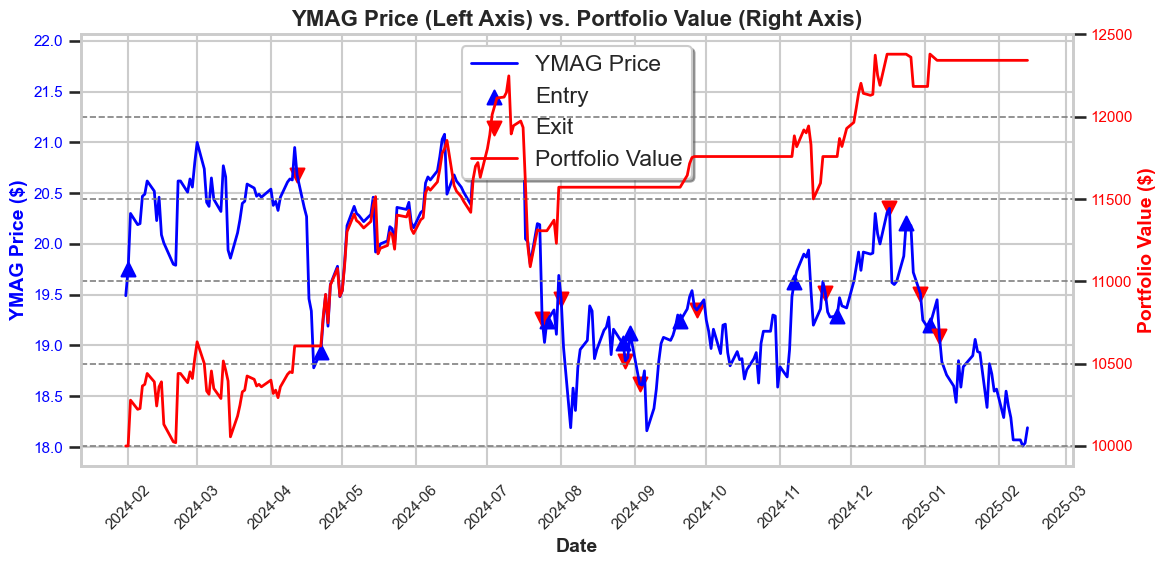

In [14]:
# ---------------------------------------------
# STEP A: Identify Entry and Exit Days for YMAG
# ---------------------------------------------
# Entry Day = Yesterday was out of market, today is in market
ymag_df["Entry"] = (ymag_df["In_Market"].shift(1) == False) & (ymag_df["In_Market"] == True)

# Exit Day = Yesterday was in market, today is out of market
ymag_df["Exit"] = (ymag_df["In_Market"].shift(1) == True) & (ymag_df["In_Market"] == False)

# ---------------------------------------------
# STEP B: Prepare Data for Plotting
# ---------------------------------------------
entry_days = ymag_df[ymag_df["Entry"] == True]
exit_days  = ymag_df[ymag_df["Exit"] == True]

# Sort data by date (just to be safe)
ymag_df.sort_values("Date", inplace=True)
ymag_df.reset_index(drop=True, inplace=True)

# ---------------------------------------------
# STEP C: Create the Dual-Axis Plot for YMAG
# ---------------------------------------------
sns.set_style("whitegrid")
fig, ax1 = plt.subplots(figsize=(12, 6))

# LEFT Y-AXIS: Plot YMAG Price
ax1.set_xlabel("Date", fontsize=14, fontweight="bold")
ax1.set_ylabel("YMAG Price ($)", fontsize=14, fontweight="bold", color="blue")

# Plot YMAG Price line
line1, = ax1.plot(
    ymag_df["Date"],
    ymag_df["YMAG"],
    color="blue",
    linewidth=2,
    label="YMAG Price"
)

# Add entry (^) and exit (v) markers on YMAG Price
ax1.scatter(
    entry_days["Date"], 
    entry_days["YMAG"], 
    marker="^", 
    color="blue", 
    s=100, 
    label="Entry"
)
ax1.scatter(
    exit_days["Date"], 
    exit_days["YMAG"], 
    marker="v", 
    color="red",
    s=100, 
    label="Exit"
)

# Make the left y-axis text blue for clarity
ax1.tick_params(axis='y', labelcolor="blue")

# Format the date axis on x-axis
ax1.xaxis.set_major_locator(mdates.MonthLocator())
ax1.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, fontsize=11)
plt.yticks(fontsize=11)

# ---------------------------------------------
# RIGHT Y-AXIS: Plot Portfolio Value
# ---------------------------------------------
ax2 = ax1.twinx()  # share the same x-axis
ax2.set_ylabel("Portfolio Value ($)", fontsize=14, fontweight="bold", color="red")

line2, = ax2.plot(
    ymag_df["Date"],
    ymag_df["Portfolio_Value"],
    color="red",
    linewidth=2,
    label="Portfolio Value"
)
ax2.tick_params(axis='y', labelcolor="red")
plt.yticks(fontsize=11)

# ---------------------------------------------
# STEP D: Enhance the Plot
# ---------------------------------------------
plt.title("YMAG Price (Left Axis) vs. Portfolio Value (Right Axis)", fontsize=16, fontweight="bold")
plt.grid(True, linestyle="--", linewidth=1.2, color="gray")

# Combine legends from both axes
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc="upper center", frameon=True, shadow=True)

plt.tight_layout()
plt.show()


In [15]:
# ---------------------------------------------
# STEP A: Identify Entry and Exit Days for YMAG
# ---------------------------------------------
ymag_df["Entry"] = (ymag_df["In_Market"].shift(1) == False) & (ymag_df["In_Market"] == True)
ymag_df["Exit"]  = (ymag_df["In_Market"].shift(1) == True) & (ymag_df["In_Market"] == False)

# ---------------------------------------------
# STEP B: Prepare Data for Plotting
# ---------------------------------------------
entry_days = ymag_df[ymag_df["Entry"] == True]
exit_days  = ymag_df[ymag_df["Exit"] == True]

# Sort data by date (just to be safe)
ymag_df.sort_values("Date", inplace=True)
ymag_df.reset_index(drop=True, inplace=True)

# ---------------------------------------------
# STEP C: Create the Plotly Figure for YMAG
# ---------------------------------------------
fig = go.Figure()

# 1) YMAG Price (Left Axis)
fig.add_trace(
    go.Scatter(
        x=ymag_df["Date"],
        y=ymag_df["YMAG"],
        mode="lines",
        line=dict(color="blue", width=2),
        name="YMAG Price",
        yaxis="y1"
    )
)

# 2) Entry Markers (triangle-up)
fig.add_trace(
    go.Scatter(
        x=entry_days["Date"],
        y=entry_days["YMAG"],
        mode="markers",
        marker=dict(symbol="triangle-up", color="blue", size=12),
        name="Entry",
        yaxis="y1"
    )
)

# 3) Exit Markers (triangle-down)
fig.add_trace(
    go.Scatter(
        x=exit_days["Date"],
        y=exit_days["YMAG"],
        mode="markers",
        marker=dict(symbol="triangle-down", color="red", size=12),
        name="Exit",
        yaxis="y1"
    )
)

# 4) Portfolio Value (Right Axis)
fig.add_trace(
    go.Scatter(
        x=ymag_df["Date"],
        y=ymag_df["Portfolio_Value"],
        mode="lines",
        line=dict(color="red", width=2),
        name="Portfolio Value",
        yaxis="y2"
    )
)

# ---------------------------------------------
# STEP D: Configure Layout for Dual Axis and Legend Position
# ---------------------------------------------
fig.update_layout(
    title="YMAG Price (Left Axis) vs. Portfolio Value (Right Axis) - Interactive Plotly",
    xaxis=dict(
        title="Date",
        type="date",
        tickformat="%Y-%m",
        tickangle=45
    ),
    yaxis=dict(
        title="YMAG Price ($)",
        side="left",
        showgrid=False,
        color="blue"
    ),
    yaxis2=dict(
        title="Portfolio Value ($)",
        side="right",
        overlaying="y",
        position=1.0,
        showgrid=True,
        gridwidth=1,
        gridcolor="lightgray",
        color="red"
    ),
    legend=dict(
        x=0.5,
        y=1.0,
        xanchor='center',
        yanchor='top',
        bgcolor="rgba(255,255,255,0.7)",
        bordercolor="black",
        borderwidth=1
    ),
    hovermode="x unified"
)

# ---------------------------------------------
# STEP E: Show Interactive Figure
# ---------------------------------------------
fig.show()


In [16]:
# ------------------------------------------------------------
# 1) COMPUTE PERFORMANCE METRICS FOR YMAG
# ------------------------------------------------------------

# Compute daily returns from portfolio value for YMAG
ymag_df["Portfolio_Return"] = ymag_df["Portfolio_Value"].pct_change()

performance_metrics_ymag = {}

# Total Return (%) for YMAG
performance_metrics_ymag["Total Return (%)"] = (ymag_df["Portfolio_Value"].iloc[-1] / ymag_df["Portfolio_Value"].iloc[0] - 1) * 100

# CAGR (Compounded Annual Growth Rate) for YMAG
num_days = (ymag_df["Date"].iloc[-1] - ymag_df["Date"].iloc[0]).days
years = num_days / 365
performance_metrics_ymag["CAGR (%)"] = ((ymag_df["Portfolio_Value"].iloc[-1] / ymag_df["Portfolio_Value"].iloc[0]) ** (1 / years) - 1) * 100

# Annualized Volatility (%) for YMAG
performance_metrics_ymag["Annualized Volatility (%)"] = ymag_df["Portfolio_Return"].std() * np.sqrt(252) * 100

# Sharpe Ratio for YMAG (assuming risk-free rate = 2%)
risk_free_rate = 0.02
sharpe_ratio_ymag = (performance_metrics_ymag["CAGR (%)"] / 100 - risk_free_rate) / (performance_metrics_ymag["Annualized Volatility (%)"] / 100)
performance_metrics_ymag["Sharpe Ratio"] = sharpe_ratio_ymag

# Max Drawdown (%) Calculation for YMAG
rolling_max_ymag = ymag_df["Portfolio_Value"].cummax()
drawdown_ymag = (ymag_df["Portfolio_Value"] / rolling_max_ymag) - 1  # Decimal values
drawdown_percentage_ymag = drawdown_ymag * 100  # Convert to percentage
performance_metrics_ymag["Max Drawdown (%)"] = drawdown_percentage_ymag.min()  # Most negative value

# Calmar Ratio for YMAG (CAGR divided by absolute Max Drawdown)
max_drawdown_abs_ymag = abs(performance_metrics_ymag["Max Drawdown (%)"])
performance_metrics_ymag["Calmar Ratio"] = performance_metrics_ymag["CAGR (%)"] / max_drawdown_abs_ymag if max_drawdown_abs_ymag != 0 else np.nan

# Convert performance metrics to a DataFrame for display
performance_df_ymag = pd.DataFrame(performance_metrics_ymag, index=["YMAG Strategy 2"])


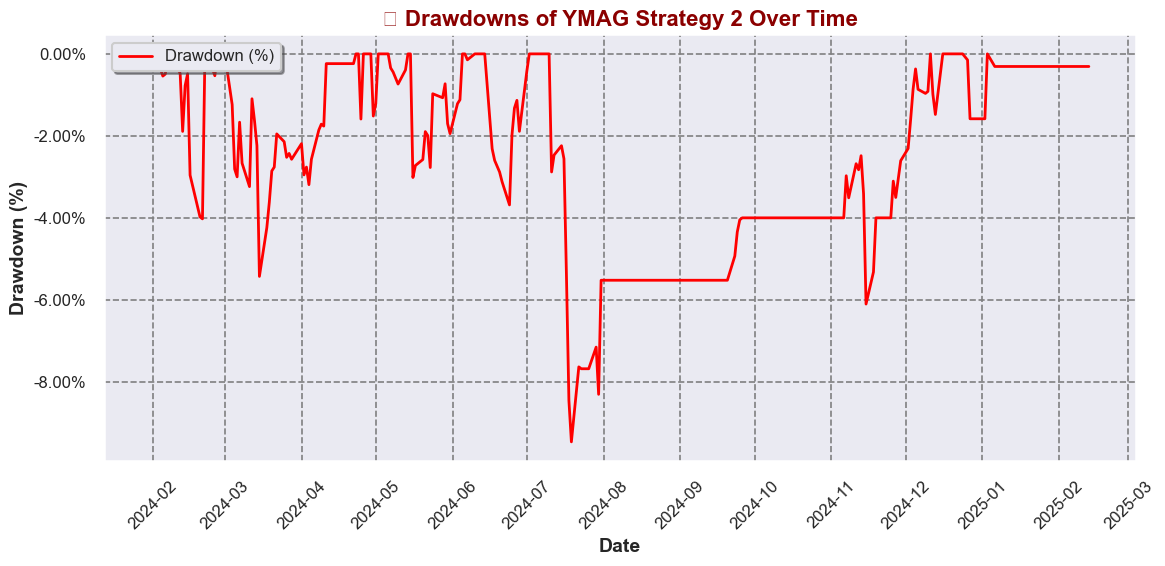

In [17]:
# ------------------------------------------------------------
# 2) PLOT DRAWDOWNS OVER TIME FOR YMAG
# ------------------------------------------------------------
sns.set_style("darkgrid")
plt.figure(figsize=(12, 6))

ax = sns.lineplot(
    x=ymag_df["Date"],
    y=drawdown_percentage_ymag,
    color="red",
    linewidth=2,
    label="Drawdown (%)"
)

# Format X-axis to display one tick per month
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y-%m"))
plt.xticks(rotation=45, fontsize=12)
plt.yticks(fontsize=12)

# Format Y-axis labels to show percentages with two decimal places
ax.yaxis.set_major_formatter(mticker.FuncFormatter(lambda y, pos: f"{y:.2f}%"))

plt.xlabel("Date", fontsize=14, fontweight="bold")
plt.ylabel("Drawdown (%)", fontsize=14, fontweight="bold")
plt.title("📉 Drawdowns of YMAG Strategy 2 Over Time", fontsize=16, fontweight="bold", color="darkred")

# Add thicker, colored grid lines for better visibility
plt.grid(True, linestyle="--", linewidth=1.2, color="gray")
plt.legend(fontsize=12, loc="upper left", frameon=True, shadow=True)
plt.tight_layout()
plt.show()


In [18]:
# Display the performance metrics for YMAX
performance_df_ymag = performance_df_ymag.round(2)
performance_df_ymag

,Total Return (%),CAGR (%),Annualized Volatility (%),Sharpe Ratio,Max Drawdown (%),Calmar Ratio
YMAG Strategy 2,23.43,22.47,14.03,1.46,-9.47,2.37


## Export DataFrames to Excel

In [19]:
# 1️⃣ Convert portfolio returns to 2-decimal percentage
ymax_df["Portfolio_Return"] = (ymax_df["Portfolio_Return"] * 100).round(2)
ymag_df["Portfolio_Return"] = (ymag_df["Portfolio_Return"] * 100).round(2)

# 2️⃣ Rename the 'Portfolio_Return' column to 'Portfolio_Return (%)'
ymax_df.rename(columns={"Portfolio_Return": "Portfolio_Return (%)"}, inplace=True)
ymag_df.rename(columns={"Portfolio_Return": "Portfolio_Return (%)"}, inplace=True)

# 3️⃣ Export the data to Excel
output_filename = "Strategy 3 Performance.xlsx"

with pd.ExcelWriter(output_filename, engine="xlsxwriter") as writer:
    # Sheet 1: Raw data (Prices_and_stats_df)
    data.to_excel(writer, sheet_name="Prices Data", index=False)
    
    # Sheet 2: YMAX trading results
    ymax_df.to_excel(writer, sheet_name="Ymax Trading Results", index=False)
    
    # Sheet 3: YMAG trading results
    ymag_df.to_excel(writer, sheet_name="YMAG Trading Results", index=False)
    
    # Sheet 4: YMAX Performance Metrics
    performance_df_ymax.to_excel(writer, sheet_name="YMAX Performance", index=True)

    # Sheet 5: YMAG Performance Metrics
    performance_df_ymag.to_excel(writer, sheet_name="YMAG Performance", index=True)

print(f"✅ All DataFrames successfully saved to '{output_filename}'")


✅ All DataFrames successfully saved to 'Strategy 3 Performance.xlsx'
